# KIste - Gestenerkennung

Code basierend auf: https://github.com/MorrisOh/German-FingerAlphabet-Detection/blob/main/sign_recognition_project.ipynb

In [75]:
# Training data path
training_data_path = './data/thumbs_v3'
model_path = './models/thumbs_v3.keras'

## Setup

In [60]:
import cv2
import mediapipe as mp
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from path import Path

from keras.models import Sequential, load_model
from keras.layers import Dense

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [61]:
def draw_results(results, image):
    # Draw hand landmarks of each hand.
    annotated_image = image.copy()

    if results is None or results.multi_hand_landmarks is None:
       return annotated_image

    for hand_landmarks in results.multi_hand_landmarks:
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
      return annotated_image

def visualize_keypoints(results):
  for hand_world_landmarks in results.multi_hand_world_landmarks:
    mp_drawing.plot_landmarks(hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)

In [62]:
def landmark_to_feature(results):
    feature_vector = []
    # If a hand got detected
    if not is_hand_present(results):
        return feature_vector

    for hand_landmarks in results.multi_hand_landmarks:
        # For each 21 keypoints, append the x, y, z coordinates
        # to the feature vector --> len(feature_vector) = 63
        for keypoint in mp_hands.HandLandmark:
            feature_vector.append(hand_landmarks.landmark[keypoint].x)
            feature_vector.append(hand_landmarks.landmark[keypoint].y)
            feature_vector.append(hand_landmarks.landmark[keypoint].z)

    return feature_vector

def is_hand_present(results):
    return results is not None and results.multi_hand_landmarks is not None and len(results.multi_handedness) > 0

In [63]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [64]:
def num_files_in_dir(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

## Record Training Data

In [65]:
# Open the camera

#  0 ... back camera
#  1 ... front camera
cap = cv2.VideoCapture(1)

detect_hands = True
is_recording = False

output_path = Path(training_data_path)

class_names = ['thumb_up', 'thumb_down', 'fist', 'peace']
class_index = 0

features = []
labels = []

with mp_hands.Hands(static_image_mode=False,
                    max_num_hands=1,
                    min_detection_confidence=0.3) as hands:

    while True:
        # Read a frame from the camera
        ret, frame = cap.read()
        frame_vis = frame.copy()

        if not ret:
            print('Error reading the frame')
            break
        
        if detect_hands:
            results = hands.process(frame)
            frame_vis = draw_results(results, frame_vis)

        # Save the actual frame to the disk
        data_out_path = output_path / class_names[class_index]
        ensure_dir(data_out_path)
        
        # Display status
        class_name = class_names[class_index]
        num_class_samples = num_files_in_dir(data_out_path)
        frame_vis = cv2.putText(frame_vis, f'Class: {class_name}', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        frame_vis = cv2.putText(frame_vis, f'Num Frames: {num_class_samples}', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        if is_recording:
            # Update the status
            frame_vis = cv2.putText(frame_vis, f'Recording', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

            if is_hand_present(results):
                # Save the actual frame to the disk
                data_out_path = output_path / class_names[class_index]
                ensure_dir(data_out_path)
                filename = data_out_path / f"{class_name}_{num_class_samples:05d}.png"
                cv2.imwrite(filename, frame)

                # Add features and labels
                filename_feat = data_out_path / f"{class_name}_{num_class_samples:05d}.csv"
                with open(filename_feat, 'w') as file:
                    features = landmark_to_feature(results)
                    for feature in features:
                        file.write(f'{feature},')
                    file.write(f'{class_name}\n')
                
                #features.append(landmark_to_feature(results))
                #labels.append(class_name)

        # Check if the "r" key is pressed
        key = cv2.waitKey(1) & 0xFF

        if key == ord('r'):
            # Toggle recording
            is_recording = not is_recording
        elif key == ord('d'):
            # Toggle hand detection
            detect_hands = not detect_hands
        elif key == ord('n'):
            class_index = (class_index + 1) % len(class_names)
        elif key == ord('p'):
            class_index = (class_index - 1) % len(class_names)
        elif key == ord('q'):
            # Check if the "q" key is pressed to exit the loop
            break

        # Display the frame
        cv2.imshow('Camera', frame_vis)
        

# Release the camera and close all windows
cap.release()
cv2.destroyAllWindows()


In [66]:
cap.release()

## Training

In [67]:
## Load the training data
import pandas as pd
import glob

dataset_path = Path(training_data_path)

# Get a list of all CSV files in a directory
csv_files = dataset_path.glob('**/*.csv')

# Create an empty dataframe to store the combined data
data = pd.DataFrame()

# Loop through each CSV file and append its contents to the combined dataframe
for csv_file in csv_files:
    df = pd.read_csv(csv_file, header=None)
    data = pd.concat([data, df])

features = data.iloc[:, :-1]
labels = data.iloc[:, -1]

<AxesSubplot:title={'center':'Number of samples per class'}>

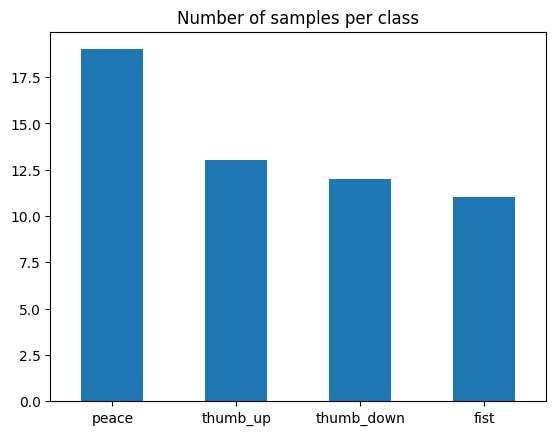

In [68]:
labels.value_counts().plot(kind='bar', title='Number of samples per class', rot=0)


In [69]:
labels_one_hot = pd.get_dummies(labels)

In [70]:
feat_trn, feat_val_tst, labels_trn, labels_val_tst = train_test_split(features, labels_one_hot, test_size=0.2, random_state=42, stratify=labels_one_hot)
feat_val, feat_tst, labels_val, labels_tst = train_test_split(feat_val_tst, labels_val_tst, test_size=0.5, random_state=42, stratify=labels_val_tst)

In [71]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

num_input_features = feat_trn.shape[1]
num_classes = labels_trn.shape[1]

epochs = 20
batch_size = 16
model_name = Path(model_path)


# Define the model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(num_input_features,)))  # First hidden layer
model.add(Dense(32, activation='relu'))  # Second hidden layer
model.add(Dense(num_classes, activation='softmax'))  # Output layer with 4 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)

# Train the model
model.fit(feat_trn, labels_trn, 
          epochs=epochs, batch_size=batch_size, 
          validation_data=(feat_val, labels_val), 
          callbacks=[checkpoint, reduce_lr])





Epoch 1/20
3/3 [==============================] - 2s 129ms/step - loss: 1.3958 - accuracy: 0.2045 - val_loss: 1.3381 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - 0s 45ms/step - loss: 1.3321 - accuracy: 0.1591 - val_loss: 1.2989 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 0s 23ms/step - loss: 1.3016 - accuracy: 0.3409 - val_loss: 1.2668 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 4/20
3/3 [==============================] - 0s 21ms/step - loss: 1.2713 - accuracy: 0.3409 - val_loss: 1.2393 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 5/20
3/3 [==============================] - 0s 19ms/step - loss: 1.2408 - accuracy: 0.3409 - val_loss: 1.2162 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 6/20
3/3 [==============================] - 0s 17ms/step - loss: 1.2209 - accuracy: 0.3409 - val_loss: 1.1977 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 7/20
3/3 [==============================] - 0s 17ms/step - loss: 1.1991 - accurac

In [72]:
# Save the class labels as csv
column_names_df = pd.DataFrame(None, columns=labels_trn.columns)

# Save to CSV
column_names_df.to_csv(model_name.with_suffix('.csv'), index=False)

## Prediction

In [76]:
model = load_model(model_path)
class_names = np.loadtxt(Path(model_path).with_suffix('.csv'), dtype=str, delimiter=',')

# Open the camera

#  0 ... back camera
#  1 ... front camera
cap = cv2.VideoCapture(1)

detect_hands = True
predict_gesture = True

with mp_hands.Hands(static_image_mode=False,
                    max_num_hands=1,
                    min_detection_confidence=0.3) as hands:

    while True:
        # Read a frame from the camera
        ret, frame = cap.read()
        frame_vis = frame.copy()

        if not ret:
            print('Error reading the frame')
            break
        
        if detect_hands:
            results = hands.process(frame)
            frame_vis = draw_results(results, frame_vis)

        if detect_hands and predict_gesture and is_hand_present(results):
            features = landmark_to_feature(results)
            score = model.predict(np.array([features]), batch_size=1)
            pred_label = class_names[np.argmax(score[0])]
            pred_score = np.max(score[0])
            
            frame_vis = cv2.putText(frame_vis, f'Class: {pred_label}, Score: {pred_score}', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)


        # Check if the "r" key is pressed
        key = cv2.waitKey(1) & 0xFF

        if key == ord('p'):
            # Toggle prediction
            predict_gesture = not predict_gesture
        elif key == ord('d'):
            # Toggle hand detection
            detect_hands = not detect_hands
        elif key == ord('q'):
            # Check if the "q" key is pressed to exit the loop
            break

        # Display the frame
        cv2.imshow('Camera', frame_vis)
        

# Release the camera and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step
